In [75]:
import numpy as np
import matplotlib.pyplot as plt
from operator import add

## Q1

In [76]:
# create transition matrix for action: not dispatch
tran_matrix_0 = np.zeros(shape=(201,201))
for row in range(0,201):
    for i in range(row+1,row+6):
        if i < 201:
            tran_matrix_0[row][i] = 0.2
            
tran_matrix_0[196, 200] = 0.4
tran_matrix_0[197, 200] = 0.6
tran_matrix_0[198, 200] = 0.8
tran_matrix_0[199, 200] = 1
tran_matrix_0[200, 200] = 1

In [77]:
# create transition matrix for action: dispatch
tran_matrix_1 = np.zeros(shape=(201,201))
for row in range(0,201):
    for i in range(row-14,row-9):
        if (i < 201) and (i >=0):
            tran_matrix_1[row][i] = 0.2
            
        if i < 0:
            tran_matrix_1[row][0] = 1
            
tran_matrix_1[13,0] = 0.4
tran_matrix_1[12,0] = 0.6
tran_matrix_1[11,0] = 0.8
tran_matrix_1[10,0] = 1

In [78]:
# create {current_state1: {action:[[prob, next_state1, reward],[prob, next_state2, reward]], action2:[]}, current_state2...}
env_P = {}
for i in range(0,201):
    env_P[i] = {}
    env_P[i][0] = []
    for j in range(0,201):
        prob = tran_matrix_0[i, j]
        if prob > 0:
            env_P[i][0].append([prob, j, i*(-2)])
        else:
            env_P[i][0].append([0, j, i*(-2)])

for i in range(0,201):
    env_P[i][1] = []
    for j in range(0,201):
        prob = tran_matrix_1[i, j]
        if prob > 0:
            env_P[i][1].append([prob, j, -100 + max(i-15, 0) * (-2)])
        else:
            env_P[i][1].append([0, j, -100 + max(i-15, 0) * (-2)])

## Enumeration

In [86]:
def one_step_lookahead(state, V, env_P, discount_factor=0.95):
    A = np.zeros(2)
    for action in range(0,2):
        for prob, next_state, reward in env_P[state][action]:
            # Calculate the expected value for each action given a state
            A[action] += prob * (reward + discount_factor * V[next_state])
    return A

In [91]:
def enumeration(env_P, num_state, T=500, discount_factor=0.95):
    V = np.zeros((num_state, T+1))
    policy = np.zeros([num_state, 2, T])
    
    for t in range(T-1, -1, -1):
        for state in range(num_state):
            A = one_step_lookahead(state, V[:, t+1], env_P)
            best_action_value = np.max(A)
            # Update the value function
            V[state,t] = best_action_value
            best_action = np.argmax(A)
            policy[state, best_action, t] = 1.0
            
    return policy, V[:, 0:T]

In [92]:
policy_enu, V_enu = enumeration(env_P, 201)

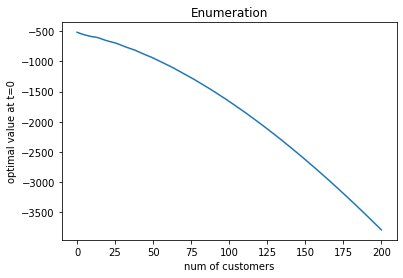

In [93]:
num_cust = list(range(0,201))
plt.plot(num_cust, V_enu[:, 0])
plt.xlabel('num of customers')
plt.ylabel('optimal value at t=0')
plt.title('Enumeration')
plt.show()

## Value Iteration

In [54]:
def value_iterate(env_P, num_state, threshold=0.0001, discount_factor=0.95):
    # Initialize value for each state
    V = np.zeros(201)
    
    while True:
        delta = 0
        # Update max reward for each state
        for state in range(num_state):
            # Bellman’s Optimality Equation
            A = np.zeros(2)
            for action in range(2):
                for prob, next_state, reward in env_P[state][action]:
                    # Calculate expected value
                    A[action] += prob * (reward + discount_factor * V[next_state])
            
            best_action_value = np.max(A)
            # Calculate reward difference across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[state]))
            # Update the value function
            V[state] = best_action_value     
        # Check if we can stop 
        if delta < threshold:
            break
    
    # Create a policy using the optimal value function for only once
    policy = np.zeros([num_state, 2])
    for state in range(num_state):
        # Bellman’s Optimality Equation
        A = np.zeros(2)
        for action in range(2):
            for prob, next_state, reward in env_P[state][action]:
                A[action] += prob * (reward + discount_factor * V[next_state])
        best_action = np.argmax(A)
        # Take the best action
        policy[state, best_action] = 1.0
    
    return policy, V

In [ ]:
policy_val, V_val = value_iterate(env_P, 201)

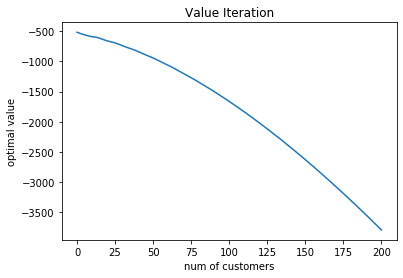

In [56]:
num_cust = list(range(0,201))
plt.plot(num_cust, V_val)
plt.xlabel('num of customers')
plt.ylabel('optimal value')
plt.title('Value Iteration')
plt.show()

## Policy Iteration

In [50]:
def policy_eval(policy, env_P, num_state, discount_factor=0.95, threshold=0.0001):
    # Initialize value function 
    V = np.zeros(num_state)
    
    while True:
        delta = 0
        for state in range(0, num_state):
            v = 0
            # The possible next actions: dispatch & not dispatch
            for action, action_prob in enumerate(policy[state]): 
                # For each action, look at the possible next states, 
                for prob, next_state, reward in env_P[state][action]: 
                    # Calculate the expected value function using Bellman’s Optimality Equation
                    v += action_prob * prob * (reward + discount_factor * V[next_state]) 
            
            # Change in value function 
            delta = max(delta, np.abs(v - V[state]))
            V[state] = v
            
        # Stop evaluating if convergency
        if delta < threshold:
            break
            
    return np.array(V)

In [51]:
def policy_improve(env_P, num_state, discount_factor=0.95):
    # Initiallize a policy arbitarily
    policy = np.ones([num_state, 2]) / 2
    
    while True:
        # Compute the Value Function for the current policy
        V = policy_eval(policy, env_P, num_state)
        
        policy_stable = True
        
        # Improve the policy at each state
        for state in range(0, num_state):
            # The best action we would select given the currect policy
            chosen_action = np.argmax(policy[state])
            # Bellman’s Optimality Equation
            action_val = np.zeros(2)
            for action in range(2):
                for prob, next_state, reward in env_P[state][action]:
                    action_val[action] += prob * (reward + discount_factor * V[next_state])
            best_action = np.argmax(action_val)
            
            # Update the policy if not convergency
            if chosen_action != best_action:
                policy_stable = False
            policy[state] = np.eye(2)[best_action]
        
        # Until convergency
        if policy_stable:
            return policy, V

In [ ]:
policy_pol, V_pol = policy_improve(env_P, 201)

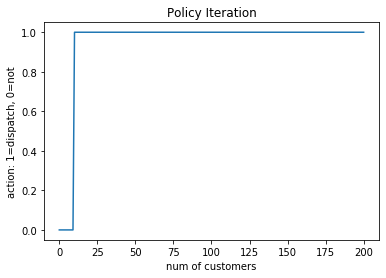

In [53]:
num_cust = list(range(0,201))
actions = [np.argmax(action) for action in policy_pol]
plt.plot(num_cust, actions)
plt.xlabel('num of customers')
plt.ylabel('action: 1=dispatch, 0=not')
plt.title('Policy Iteration')
plt.show()

## Q2

In [ ]:
# find all states
# There are 5 types of customers and each type can have [0, 100] people waiting. 
# The total number of state is 101^5 = 10510100501, which is too large for those algorithms
cust_cost = [1, 1.5, 2, 2.5, 3]
state_t = []
for cust1 in range(0, 101):
    for cust2 in range(0, 101):
        for cust3 in range(0, 101):
            for cust4 in range(0, 101):
                 for cust5 in range(0, 101):
                        state_t.append([cust1, cust2, cust3, cust4, cust5])
print(len(state_t))                            

In [ ]:
# find all next states if not dispatch
new_come = []
for cust1 in range(0, 6):
    for cust2 in range(0, 6):
        for cust3 in range(0, 6):
            for cust4 in range(0, 6):
                for cust5 in range(0, 6):
                    new_come.append([cust1, cust2, cust3, cust4, cust5])
                    
transition_matrix_0 = []
for s in state_t:
    for delta_s in new_come:
        s1 = list(map(add, s, delta_s))
        # max customer for each type is 100
        s1 = [100 if i >= 100 else i for i in s1]
        s1 = [0 if i < 0 else i for i in s1]
        # max customer in total is 200
        if sum(s1) <= 200:
            transition_matrix_0.append([s, s1])

In [ ]:
# find all rewards if not dispatch
env_P = {}
prob = 1 / len(transition_matrix_0) 
for s_s1 in transition_matrix_0:
    env_P[s_s1[0]] = {}
    env_P[s_s1[0]][0] = []
    reward = s * (-2)
    env_P[s_s1[0]][0].append([prob, s_s1[1], reward])

In [ ]:
# find all next states if dispatch
leave_cust = []
for cust1 in range(0, 30):
    for cust2 in range(0, 30):
        for cust3 in range(0, 30):
            for cust4 in range(0, 30):
                 for cust5 in range(0, 30):
                        if cust1 + cust2 + cust3 + cust4 + cust5 = 30:
                            leave_cust.append([cust1, cust2, cust3, cust4, cust4])
                            
delta_cust = list(map(add, new_come, leave_cust))
transition_matrix_1 = []
for s in state_t:
    for delta_s in delta_cust:
        s1 = list(map(add, s, delta_s))
        s1 = [100 if i >= 100 else i for i in s1]
        s1 = [0 if i < 0 else i for i in s1]
        if sum(s1) <= 200:
            transition_matrix_1.append([s, s1, delta_s])

In [ ]:
# find all rewards if dispatch
ch = [1, 1.5, 2, 2.5, 3]
prob1 = 1 / len(transition_matrix_0)
for s_s1 in transition_matrix_0:
    s = s_s1[0]
    s1 = s_s1[1]
    delta = s_s1[2]
    
    env_P[s][1] = []
    reward = -100 - ch[0]*max(s[0]-delta[0], 0) - ch[1]*max(s[1]-delta[1], 0) - ch[2]*max(s[2]-delta[2], 0) - ch[3]*max(s[3]-delta[3], 0) - ch[4]*max(s[4]-delta[4], 0)               
    env_P[s][1].append([prob1, s1, reward])

In [ ]:
# enumeration
policy_enu, V_enu = enumeration(env_P, 10510100501)
# value iteration
policy_val, V_val = value_iterate(env_P, 10510100501)
# policy iteration
policy_pol, V_pol = policy_improve(env_P, 10510100501)